In [3]:
import nltk

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

C:\Users\Jimit\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
data = pd.read_csv('fin.csv', error_bad_lines=False);
data_text = data[['finance']]

In [5]:
data_text['index'] = data_text.index
documents = data_text

In [6]:
data = documents['finance'].values.tolist()

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
data_words = list(sent_to_words(data))

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    #i=0
    for sent in texts:
        #print(i)
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        #i=i+1
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

In [11]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [19]:
#print(data_lemmatized[:1])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"firm" + 0.009*"bank" + 0.006*"financial" + 0.005*"value" + '
  '0.005*"year" + 0.005*"variable" + 0.005*"effect" + 0.005*"market" + '
  '0.005*"use" + 0.004*"control"'),
 (1,
  '0.026*"return" + 0.014*"stock" + 0.014*"portfolio" + 0.013*"market" + '
  '0.011*"fund" + 0.009*"trade" + 0.009*"table" + 0.008*"use" + 0.007*"high" + '
  '0.007*"average"'),
 (2,
  '0.015*"risk" + 0.012*"model" + 0.009*"price" + 0.007*"portfolio" + '
  '0.006*"time" + 0.006*"use" + 0.006*"asset" + 0.005*"volatility" + '
  '0.005*"market" + 0.005*"strategy"')]


In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.879229182238127

Coherence Score:  0.363904862432999


In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

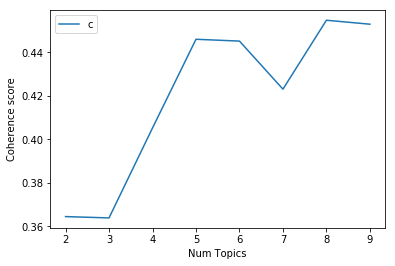

In [17]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3645
Num Topics = 3  has Coherence Value of 0.3639
Num Topics = 4  has Coherence Value of 0.4052
Num Topics = 5  has Coherence Value of 0.446
Num Topics = 6  has Coherence Value of 0.4451
Num Topics = 7  has Coherence Value of 0.4231
Num Topics = 8  has Coherence Value of 0.4547
Num Topics = 9  has Coherence Value of 0.4529


In [19]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0,
  '0.018*"house" + 0.016*"employment" + 0.013*"establishment" + 0.012*"bubble" '
  '+ 0.011*"household" + 0.011*"job" + 0.010*"growth" + 0.009*"labor" + '
  '0.008*"year" + 0.008*"state"'),
 (1,
  '0.035*"return" + 0.021*"portfolio" + 0.017*"stock" + 0.016*"fund" + '
  '0.016*"market" + 0.014*"trade" + 0.009*"high" + 0.009*"strategy" + '
  '0.008*"average" + 0.008*"table"'),
 (2,
  '0.017*"model" + 0.015*"risk" + 0.009*"volatility" + 0.009*"use" + '
  '0.009*"price" + 0.007*"portfolio" + 0.007*"asset" + 0.007*"time" + '
  '0.006*"value" + 0.005*"variance"'),
 (3,
  '0.057*"wkh" + 0.026*"dqg" + 0.010*"wkdw" + 0.010*"lv" + 0.007*"epw" + '
  '0.005*"iurp" + 0.005*"uzzudau" + 0.004*"lq" + 0.004*"zh" + 0.004*"zlwk"'),
 (4,
  '0.008*"market" + 0.007*"may" + 0.006*"financial" + 0.005*"would" + '
  '0.005*"cost" + 0.005*"make" + 0.004*"see" + 0.004*"investment" + '
  '0.004*"information" + 0.004*"price"'),
 (5,
  '0.022*"firm" + 0.013*"ceo" + 0.012*"board" + 0.010*"variable" + '
  '0.009*